# video

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Input
from tensorflow.keras.optimizers import Adam

In [2]:

# Settings
DATASET_PATH = 'dataset/video'
DATASET_PATH = r"D:\\VideoAndAudio\\Video"
IMG_SIZE = 64
FRAME_SKIP = 5  # Use every 5th frame

X = []
y = []
label_map = {}
label_counter = 0

# 1. Read videos and extract frames
for emotion in os.listdir(DATASET_PATH):
    emotion_path = os.path.join(DATASET_PATH, emotion)
    if os.path.isdir(emotion_path):
        if emotion not in label_map:
            label_map[emotion] = label_counter
            label_counter += 1
        label = label_map[emotion]

        for file in os.listdir(emotion_path):
            if file.endswith('.flv'):
                video_path = os.path.join(emotion_path, file)
                cap = cv2.VideoCapture(video_path)
                frame_count = 0
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if frame_count % FRAME_SKIP == 0:
                        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                        frame = frame / 255.0  # Normalize
                        X.append(frame)
                        y.append(label)
                    frame_count += 1
                cap.release()




In [3]:
class_names = {v:k for k,v in label_map.items()}

In [4]:
X = np.array(X)
y = to_categorical(np.array(y), num_classes=len(label_map))
print(f"Data loaded: {X.shape[0]} frames, shape: {X.shape[1:]}")

Data loaded: 78 frames, shape: (64, 64, 3)


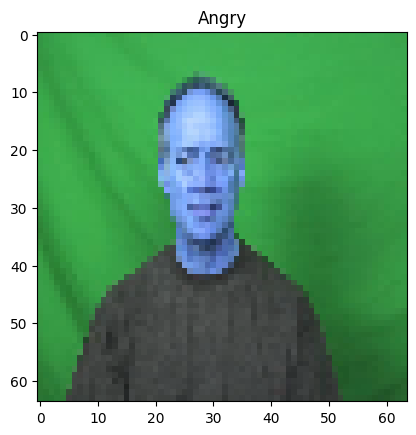

In [22]:
import matplotlib.pyplot as plt
import random
i =random.randint(0,len(X)-1)
plt.imshow(X[i])
plt.title(f"{class_names[np.argmax(y[i])]}")
plt.show()

In [6]:
y[0]

array([1., 0., 0., 0., 0., 0.])

In [7]:
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.applications import VGG16

base = VGG16(weights=None,include_top=False)

model = Sequential()

model.add(Input(shape=(64,64,3)))
model.add(base)

model.add(Flatten())
# model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,734 (57.14 MB)

 Trainable params: 14,977,734 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [154]:
from tensorflow.keras import models
model = models.load_model(r"trained_models\cnn_video_no_audio.keras")

In [13]:

# 4. Train
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.1941 - loss: 1.6600 - val_accuracy: 0.1429 - val_loss: 1.7989
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - accuracy: 0.1629 - loss: 1.6360 - val_accuracy: 0.1429 - val_loss: 1.7962
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - accuracy: 0.1525 - loss: 1.5737 - val_accuracy: 0.1429 - val_loss: 1.7986
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step - accuracy: 0.1629 - loss: 1.5363 - val_accuracy: 0.1429 - val_loss: 1.7916
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 734ms/step - accuracy: 0.1958 - loss: 1.7868 - val_accuracy: 0.1429 - val_loss: 1.7914
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step - accuracy: 0.1716 - loss: 1.7918 - val_accuracy: 0.1429 - val_loss: 1.7913
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.1612 - loss: 1.7916 - val_accuracy: 0.1429 - val_loss: 1.7913
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.1508 - loss: 1.7917 - val_accuracy: 0.1429 - val_loss:

In [12]:
# 5. Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {100*acc}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1250 - loss: 1.7546
Test Accuracy: 12.5%


In [168]:
model.save(filepath='trained_models\\cnn_video_no_audio.keras',overwrite=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


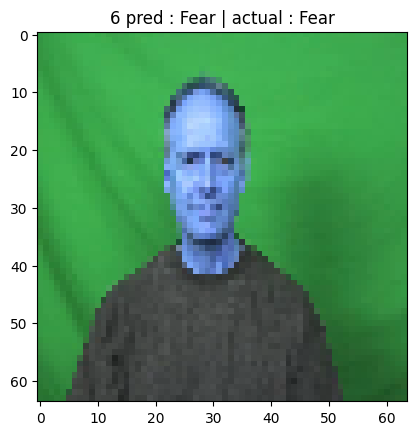

In [ ]:
import numpy as np
import random

i =random.randint(0,len(X_test)-1)
frame = X_test[i]
frame_ip = np.expand_dims(frame,axis=0)

pred = model.predict(frame_ip)
clss = class_names[np.argmax(pred)]
actual = class_names[np.argmax(y_test[0])]

plt.imshow(X_test[i])
plt.title(f"{i} pred : {clss} | actual : {actual}")
plt.show()